# Costa Rican Household Level Poverty Prediction

#### By Joseph Young


As part of the Kaggle Competition "Costa Rican Household Level Poverty Prediction" this notebook will outline the methods and models I used to produce predictions for poverty levels.

## Table of Contents
### 1. Target Analysis/ Correction
### 2. Data Analysis/ Description
### 3. Data Cleaning
### 4. Train Test Split Methodology
### 5. Prediction Models/ Optimization
### 6. Conclusions
### 7. Citations

In [10]:
#for package access
import sys
sys.path.append(r'R:\JoePriceResearch\Python\Anaconda3\Lib\site-packages')

#for directory navigation
import os

#for data processing/analytics
import pandas as pd
import numpy as np
from scipy.special import boxcox1p
from scipy.stats import boxcox

#for modeling/ prediction
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

#for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Target Analysis
Here I read in the data and examine how the target variable behaves

In [11]:
#choose filepath
os.chdir(r"C:\Users\josephwy\Documents\all")

#read in dataframes
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
train_df.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [37]:
#checks to ensure proper proper target values
train_df["Target"].unique()


array([4, 2, 3, 1], dtype=int64)

In [13]:
#defines a function to visualize data distribution
def distribution(data, x_axis, y_label, title):
    ax = sns.distplot(data[x_axis])
    ax.set_title(title)
    ax.set_ylabel(y_label)
    plt.show()

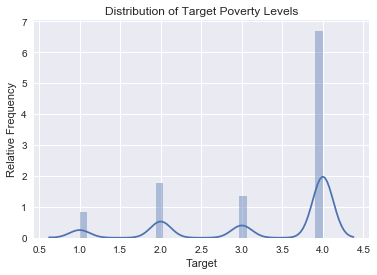

In [14]:
distribution(train_df, "Target", "Relative Frequency", "Distribution of Target Poverty Levels")

Here we see that the distribution strongly favors 4, meaning non-vulnerable households. The proportionately smaller number of Target=1 (meaning extreme poverty) means that we will want the recall rate to be high to ensure that no households are excluded. That said, precision is still important for budgetary reasons. 

We see that there are far more numeric features than categorical features. 
Next I define some scatterplot and heatmap functions for more analysis. 

In [15]:
#defines a scatterplot function
def scatterplot(data, x_column, y_column, x_label, y_label, title):
    #determines plot dimensions
    plt.figure(figsize=(10,6))
    #determines plot font size
    plt.rcParams.update({'font.size': 40})
    #inputs data and chooses axis
    plt.scatter(x_column, y_column, data=data)
    #populates axis labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.suptitle(title, fontsize=15)
    plt.show()
    
    return

#Creates a heatmap to compare the top features most correlated with saleprice
def heatmap(data, num_features, primary_feature, title):
    corrmat = data.corr()
    columns = corrmat.nlargest(num_features, primary_feature)[primary_feature].index
    cm = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=1.25)
    f, ax = plt.subplots(figsize=(14, 10))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
    plt.title(title)
    plt.show()
    
    return

#Creates a boxplot
def boxplot(data, x_column, y_column, x_label, y_label, title):
    plt.figure(figsize = (10, 6))
    sns.boxplot(x = x_column, y = y_column, data = data);
    plt.title(title);
    plt.xlabel(x_label);
    plt.ylabel(y_label);
    
    
    return
#creates a violinplot
def violinplot(data, x_column, y_column, x_label, y_label, title):
    plt.figure(figsize = (10, 6))
    sns.violinplot(x = x_column, y = y_column, data = data);
    plt.title(title);
    plt.xlabel(x_label);
    plt.ylabel(y_label);

Now I'd like to present some correlations with the target variables, but I must first resolve some missing data issues first. 

## Data Cleaning

### Missing Values
To address the missing value problem, I first determine which data is missing in both the training and test set:

### Categorical Variable Treatment

Next I index the numeric and categorical features in the dataset to analyze/ treat them seperately.

In [16]:
#Creates numeric and categorical feature lists
train_num_feat = train_df.dtypes[train_df.dtypes != "object"].index
train_cat_feat = train_df.dtypes[train_df.dtypes == "object"].index
print(len(train_num_feat))
print(len(train_cat_feat))


#does the same with testing set
test_num_feat = test_df.dtypes[test_df.dtypes != "object"].index
test_cat_feat = test_df.dtypes[test_df.dtypes == "object"].index

138
5


With the data characterized into numeric and categorical series, I can now iterate through both sets to check for missing data:

In [17]:
#creates lists of missing categorical and numerical data
numeric_missing = []
print("Missing Numeric Data (training set): \n")
for feature in train_num_feat:
    if train_df[feature].isnull().sum() > 0:
        numeric_missing.append(feature)
for feature in numeric_missing:
    print("Missing data points for " + feature + ": " + str(train_df[feature].isnull().sum()))

print("\nMissing Categorical Data (training set): \n")
cat_missing = []
for feature in train_cat_feat:
    if train_df[feature].isnull().sum() > 0:
        cat_missing.append(feature)
for feature in cat_missing:
    print("Missing data points for " + feature + ": " + str(train_df[feature].isnull().sum()))
    
    
#does the same with test set
test_num_missing = []
print("Missing Numeric Data (test set): \n")
for feature in test_num_feat:
    if test_df[feature].isnull().sum() > 0:
        test_num_missing.append(feature)
for feature in test_num_missing:
    print("Missing data points for " + feature + ": " + str(train_df[feature].isnull().sum()))

print("\nMissing Categorical Data (test set): \n")
test_cat_missing = []
for feature in test_cat_feat:
    if test_df[feature].isnull().sum() > 0:
        test_cat_missing.append(feature)
for feature in test_cat_missing:
    print("Missing data points for " + feature + ": " + str(train_df[feature].isnull().sum()))


Missing Numeric Data (training set): 

Missing data points for v2a1: 6860
Missing data points for v18q1: 7342
Missing data points for rez_esc: 7928
Missing data points for meaneduc: 5
Missing data points for SQBmeaned: 5

Missing Categorical Data (training set): 

Missing Numeric Data (test set): 

Missing data points for v2a1: 6860
Missing data points for v18q1: 7342
Missing data points for rez_esc: 7928
Missing data points for meaneduc: 5
Missing data points for SQBmeaned: 5

Missing Categorical Data (test set): 



Here we learn two things; the numeric data is riddled with missing data, but the categorical data, as well as the entire test set data are complete. 

Several of the missing features require unique treatment. I address them by treatment form below:

##### Education Data

A lot of the education data is missing because in some cases, the oldest individual in the household is 18 and is not necessarily a household head. To resolve this issue, I take the mean of these variables into a "meaneduc" variable, comprised of the mean of all individuals within a household. 

In [18]:
#averages mean of education into meaneduc column:
avg_edu_nan = train_df[train_df['meaneduc'].isnull()][['Id','idhogar','escolari']]
avg_edu=avg_edu_nan.groupby('idhogar')['escolari'].mean().reset_index()
for row in avg_edu_nan.iterrows():
    idx=row[0]
    idhogar=row[1]['idhogar']
    m=avg_edu[avg_edu['idhogar']==idhogar]['escolari'].tolist()[0]
    train_df.at[idx, 'meaneduc']=m
    train_df.at[idx, 'SQBmeaned']=m*m

##### Rent Data

v2a1 is the monthly rent payment. There are 6860 households where this is the case. However, 5911 of them own their own houses and are therefore not paying any rent. Because the remaining number is significantly smaller, it is safe to assume that there are extraneous circumstances allowing them to not pay rent, so I will just enter a 0 in this case.

In [19]:
#fills na with 0 in v2a1
train_df['v2a1']=train_df['v2a1'].fillna(0)


##### Tablet Data

The v18q1 category indicates whether a household owns a tablet. We see that there are no 0's listed in this column, and can therefore conclude that missing data is simply indicative of a household not owning a tablet. We can, therefore, just fillna with 0.

In [20]:
#fills na with 0 in v18q1
train_df['v18q1']=train_df['v18q1'].fillna(0)

##### Schooling Schedule

rez_esc describes if someone is behind in school. Closer inspection reveals that anyone without a value listed is either an adult or a child younger than school age. We can just fill those categories with 0's then. 

In [21]:
#fills na with 0 in rez_esc
train_df['rez_esc']=train_df['rez_esc'].fillna(0)

### Back to Target Analysis

Now that we've resolved the missing data problem, we can continue our investigation of the target variable. 
Below is a heatmap displaying the correlations between the 30 most correlated variables with the target and their corresponding correlations. 

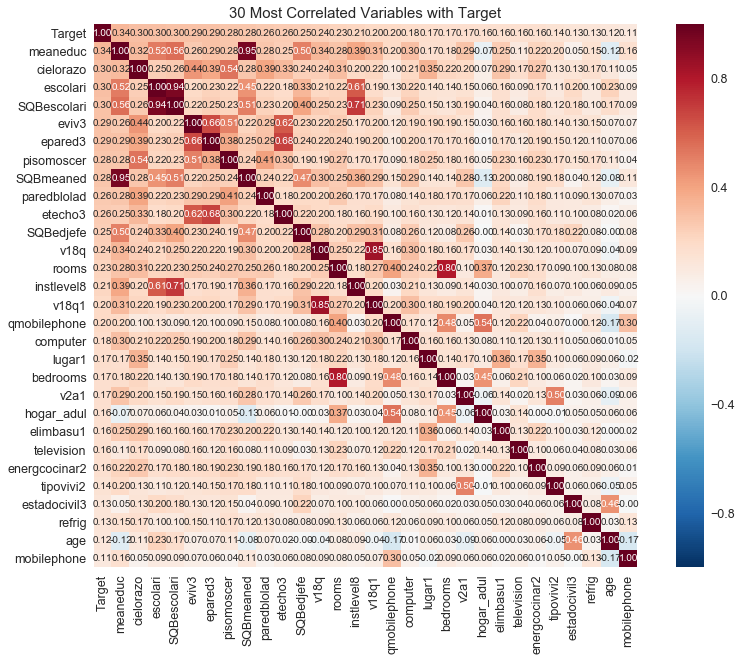

In [22]:
heatmap(train_df, 30, "Target", "30 Most Correlated Variables with Target")

As we can see, there are a handful of highly correlated variables, including SQBescolari and escolari (becasue SQB is just escolari squared) as well as v18q1 and v18q (Whether the family owns a tablet, and how many,) instlevel8 and SQBescolari, etecho3 andepared4, bedrooms and rooms, most for fairly obvious reasons--they are often modifications of eachother, albeit not perfectly colinear. For this reason I will test the models with and without these features to determine whether or not their inclusion hurts or helps the predictions. 

Below I investigate in further depth some of the highly correlated data's relationship with the Target value

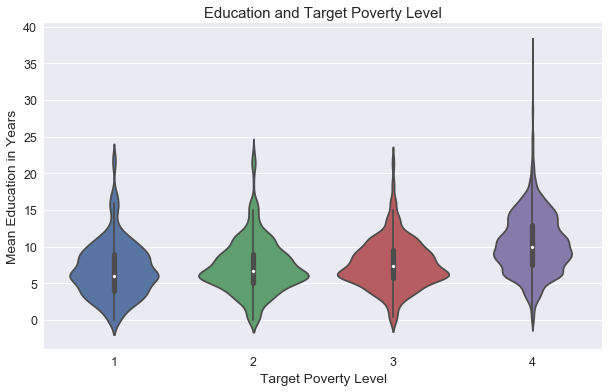

In [23]:
violinplot(train_df, "Target", "meaneduc", "Target Poverty Level", "Mean Education in Years", "Education and Target Poverty Level")

There is a clear definete preference between target levels of 4 and higher education, although the difference is not as pronounced in other categories. 

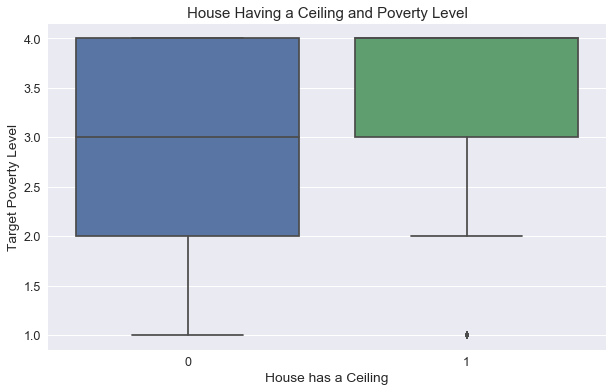

In [24]:
boxplot(train_df, "cielorazo", "Target", "House has a Ceiling", "Target Poverty Level", "House Having a Ceiling and Poverty Level")

This distribution is extremely clear; not having a ceiling tends to indicate poverty.

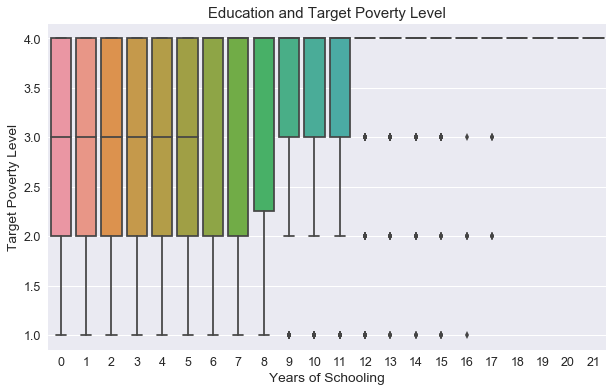

In [25]:
boxplot(train_df, "escolari", "Target", "Years of Schooling", "Target Poverty Level", "Education and Target Poverty Level")

This visualization is particularly useful; with few exceptions, though impovrished individuals can have as many as 16 years of schooling, there is a clear preference to individuals with 6 years or lower. I'd imagine that the breakdown in schooling by age and other background may be even more revealing, and likely a spot for feature engineering. 

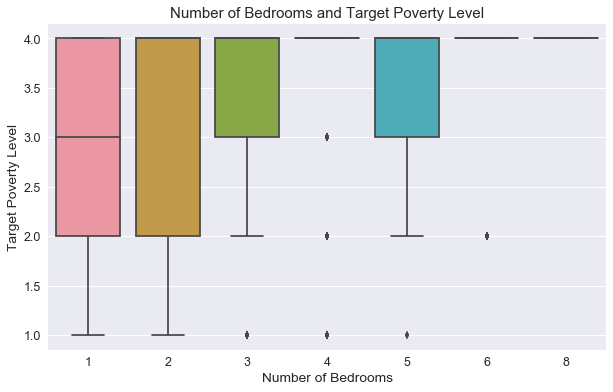

In [26]:
boxplot(train_df, "bedrooms", "Target", "Number of Bedrooms", "Target Poverty Level", "Number of Bedrooms and Target Poverty Level")

The bedroom variable was also very telling. Combinations of bedroom with other house variables may create useful features. 

#### Useless features

There are a number of useless columns that can be removed as they increase dimensionality endogenous covariance. 
Importantly, only the heads of households are used in final scoring. For this reason, some of the other ID columns can be removed as well.
As I discuss later, I try fitting both with and without these columns and find it better to remove them. (SPOILER ALERT: Their exclusion from the model didn't prove to make much of a difference with Gradient Boosting)

## Feature Engineering


Then I create an indexed dataframe comprised uniquely of categorical variables, and turn them into dummies. 
I will reincorporate the dummies into the final dataset prior to the train_test_split test. 

In [38]:
# converts categorical data into dummies. 
cat_df = train_df[train_cat_feat]
cat_df = pd.get_dummies(cat_df)

# does the same with the test set
test_cat_df = train_df[train_cat_feat]
test_cat_df = pd.get_dummies(cat_df)

cat_df.head()

,Id_ID_0005f1903,Id_ID_000603f5e,Id_ID_000694a57,Id_ID_000b240d7,Id_ID_000ba4f4f,Id_ID_00186dde5,Id_ID_001db8579,Id_ID_001ed8ac7,Id_ID_002242b5b,Id_ID_0026ce239,...,edjefa_21,edjefa_3,edjefa_4,edjefa_5,edjefa_6,edjefa_7,edjefa_8,edjefa_9,edjefa_no,edjefa_yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Roof Composition
The following changes were explained in https://www.kaggle.com/dhimananubhav/exploratory-data-analysis-lightgbm-e18daf/notebook 
as important features. The data, while it does contain some information regarding the material used in a roof and electricity, is broken down into effectively nondescript subcomponents. This function aggregates the subcomponents affiliated with roofing and electricity and produces two new variables that describe the respective house composition. 

In [28]:
#creates a feature for the roofing material and electricity
train_df['roof_waste_material'] = np.nan
train_df['electricity_other'] = np.nan

#does the same for the test set
test_df['roof_waste_material'] = np.nan
test_df['electricity_other'] = np.nan

#function that checks for the composition of the roof and returns 1 if it is composed of recyclable materials
def fill_roof_exception(x):
    if (x['techozinc'] == 0) and (x['techoentrepiso'] == 0) and (x['techocane'] == 0) and (x['techootro'] == 0):
        return 1
    else:
        return 0
    
def fill_no_electricity(x):
    if (x['public'] == 0) and (x['planpri'] == 0) and (x['noelec'] == 0) and (x['coopele'] == 0):
        return 1
    else:
        return 0

#applies function to the datasets to fill the new features
train_df['roof_waste_material'] = train_df.apply(lambda x : fill_roof_exception(x),axis=1)
test_df['roof_waste_material'] = test_df.apply(lambda x : fill_roof_exception(x),axis=1)
train_df['electricity_other'] = train_df.apply(lambda x : fill_no_electricity(x),axis=1)
test_df['electricity_other'] = test_df.apply(lambda x : fill_no_electricity(x),axis=1)


### Household Composition
The following are components I included to leverage the correlation between the number of bedrooms in a house and poverty. Breaking them down further to per person subcomponents seemed like a useful addition. In fact, the precision and recall were both improved in the K nearest neighbors and the Random Forest specification.

In [40]:
# Creates 6 new variables
train_df['adults_per_broom'] = train_df['hogar_adul']/train_df['bedrooms']
train_df['children_per_broom'] = train_df['hogar_nin']/train_df['bedrooms']
train_df['humans_per_broom'] = train_df['hhsize']/train_df['bedrooms']        
train_df['persons12less_frac'] = (train_df['r4h1'] + train_df['r4m1'])/train_df['hhsize']
train_df['males12plus_frac'] = train_df['r4h2']/train_df['hhsize']       
train_df['rent_per_person'] = train_df['v2a1']/train_df['hhsize']

#Does the same for the testing set

test_df['adults_per_broom'] = test_df['hogar_adul']/test_df['bedrooms']
test_df['children_per_broom'] = test_df['hogar_nin']/test_df['bedrooms']
test_df['humans_per_broom'] = test_df['hhsize']/test_df['bedrooms']        
test_df['persons12less_frac'] = (test_df['r4h1'] + test_df['r4m1'])/test_df['hhsize']
test_df['males12plus_frac'] = test_df['r4h2']/test_df['hhsize']       
test_df['rent_per_person'] = test_df['v2a1']/test_df['hhsize']
       

### Education Characterization
To improve schooling estimates, I included a feature that divided one's schooling by their age:

In [43]:
train_df['schooling_by_age'] = train_df['escolari'] / train_df['age']
test_df['schooling_by_age'] = test_df['escolari'] / train_df['age']

### Visualization of Engineered Features:

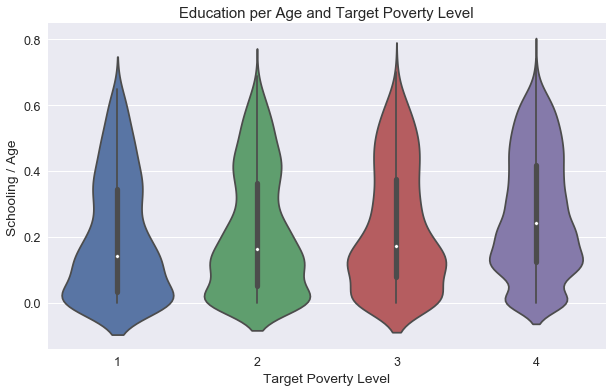

In [45]:
violinplot(train_df, "Target", "schooling_by_age", "Target Poverty Level", "Schooling / Age", "Education per Age and Target Poverty Level")

### Finalized Dataset:


In the finalized specifications, I tried out models with variations of the above features as well as with the following features dropped: 

- 'idhogar',
- 'Id', 
- 'tamhog', 
- 'agesq', 
- 'hogar_adul', 
- 'SQBescolari', 
- 'SQBage', 
- 'SQBhogar_total', 
- 'SQBedjefe', 
- 'SQBhogar_nin', 
- 'SQBovercrowding', 
- 'SQBdependency', 
- 'SQBmeaned'

These were features I found to be redundant in the correlation heatmap analysis. Ultimately, the feature exclusions seemed to make a difference in the K Nearest Neighbors model and the Random Forest, but not the Gradient Boosting. 


In [29]:
train_df_final = pd.DataFrame()

for i in train_num_feat:
    train_df_final[i] = train_df[i]

for i in cat_df.columns:
    train_df_final[i] = cat_df[i]
    
#Do the same for testing set
test_df_final = pd.DataFrame()

for i in test_num_feat:
    test_df_final[i] = test_df[i]

for i in test_cat_df.columns:
    train_df_final[i] = test_cat_df[i]

### Train Test Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(train_df_final, train_df_final["Target"],test_size=0.2, random_state=42)

## Models

I used the following models:

- Gradient Boosting
- K Nearest Neighbors
- Random Forest

I would have liked to have tried other models, but was unable to due install LGBoost on school computers. 

I started with a gridsearching function to optimize the hyperparameters for each model:


In [31]:
#defines a gridsearching function
def gridsearching(model):
    #fits the chosen model to the data
   model.fit(X_train, y_train)
    #ouputs best parameters
   print("Best Params: {}".format(model.best_params_))
   y_pred_train = model.predict(X_train)
   print("Train F1: {}".format(f1_score(y_train, y_pred_train, average="macro")))
   print("Test Classification Report:")
   y_pred_test = model.predict(X_test)
    #presents classification scores
   print(classification_report(y_test, y_pred_test))
   print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                    accuracy_score(y_test, y_pred_test)))

### Gradient Boosting

Gradient Boosting was by far the most consistent; variations in included features did not seem to influence the output. I consistently got perfect precision and recall in the training set.

My concern with this model is of course, the possibility that it overfits. To mitigate my concerns, I tried varied depth levels and number of estimators. Again, despite these changes, I maintained consistently high precision and recall. 

Though that was reassuring, I remained concerned that the iterative imporvement approach Gradient Boosting takes would overshadow changes to hyperparameters, thwarting my ability to avoid overfitting. For this reason I concluded that an ensemble method with other optimized models, even if less precise, may produce a more generalizeable model to be used in industry. 

In [32]:
Gradient_Boosting = GradientBoostingClassifier()
model = GridSearchCV(Gradient_Boosting, {"learning_rate": [.1], "n_estimators": [100,], 
                                'max_depth': [1]}, scoring='f1_macro')
gridsearching(model)

Best Params: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
Train F1: 1.0
Test Classification Report:
             precision    recall  f1-score   support

          1       1.00      1.00      1.00       164
          2       1.00      1.00      1.00       311
          3       1.00      1.00      1.00       254
          4       1.00      1.00      1.00      1183

avg / total       1.00      1.00      1.00      1912

Train Accuracy: 1.0	Test accuracy: 1.0


### K Nearest Neighbors
K Nearest Neighbors did not perform well consistently. It was highly sensitive to feature inclusion, and had an intolerably long runtime for its low precision and recall. That said, I found it to be very effective in identifying useful features for my final analysis. 

In [42]:
Random_Forest = KNeighborsClassifier()
model = GridSearchCV(Random_Forest, {'n_neighbors': [5,7], 'leaf_size': [25,30], 'p':[2]}, scoring="f1_macro")
gridsearching(model)

KeyboardInterrupt: 

### Random Forest
Random forest performed the least effectively, but was the quickest by far. I decided to not include it in my final model.

In [34]:
Random_Forest = RandomForestClassifier()
model = GridSearchCV(Random_Forest, {'max_depth': [4,5,6], 'n_estimators': [9,10,11,12]}, scoring="f1_macro")
gridsearching(model)

Best Params: {'max_depth': 6, 'n_estimators': 9}
Train F1: 0.212928460793807
Test Classification Report:
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       164
          2       1.00      0.00      0.01       311
          3       0.00      0.00      0.00       254
          4       0.62      1.00      0.76      1183

avg / total       0.55      0.62      0.47      1912

Train Accuracy: 0.6350555918901243	Test accuracy: 0.6192468619246861


## Ensembling:
Were I to produce a model for industry, I would likely use an ensemble with weighted combinations of the Gradient Boosting and K Nearest Neighbors specifications. I would do this to combine the high precision and recall rates of the GB model, with the sensitivity to data inclusion the KNN model provides to prevent overfitting. 

### Citations:

I consulted the following kernels in making this notebook:

- https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data
- https://www.kaggle.com/gaxxxx/exploratory-data-analysis-lightgbm
- https://www.kaggle.com/zhav1k/make-it-beautiful-with-seaborn-xgb-model
- https://www.kaggle.com/nicapotato/costa-rican-poverty-distributions-and-corr
- https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
- https://www.kaggle.com/katacs/data-cleaning-and-random-forest